## 1. Настройка ноутбука

In [1]:
# libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'svg'

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import\
    mean_absolute_error as MeanAE,\
    mean_squared_error as MSE,\
    median_absolute_error as MedianAE,\
    r2_score as R2

import warnings
warnings.filterwarnings('ignore')

##### Функции для обработки данных

## 2. Задание
##### Обозначения:
    p - глубина истории, сколько измерений назад учитываем в моделях
    h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

## 3 . Загрузка и просмотр данных

In [2]:
# read data
df_MW = pd.read_csv('my_PJME_MW.csv', index_col=0, parse_dates=['Date'])
df_MW.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
df_MW.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


In [4]:
df_MW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
Time               145374 non-null object
PJME_MW            145374 non-null float64
year               145374 non-null int64
month              145374 non-null int64
dayofmonth         145374 non-null int64
quarter            145374 non-null int64
dayofyear          145374 non-null int64
weekofyear         145374 non-null int64
dayofweek          145374 non-null int64
hour               145374 non-null int64
is_holiday         145374 non-null int64
is_prev_holiday    145374 non-null int64
is_next_holiday    145374 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 15.5+ MB


In [5]:
def reduction_memory(df: pd.DataFrame):
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    return df_c

In [6]:
# reduction memory size
df_MW = reduction_memory(df_MW)
df_MW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
Time               145374 non-null object
PJME_MW            145374 non-null float32
year               145374 non-null int16
month              145374 non-null int8
dayofmonth         145374 non-null int8
quarter            145374 non-null int8
dayofyear          145374 non-null int16
weekofyear         145374 non-null int8
dayofweek          145374 non-null int8
hour               145374 non-null int8
is_holiday         145374 non-null int8
is_prev_holiday    145374 non-null int8
is_next_holiday    145374 non-null int8
dtypes: float32(1), int16(2), int8(9), object(1)
memory usage: 4.6+ MB


- сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [7]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [8]:
b_ar_exp_1 = exponential_smoothing(df_MW['PJME_MW'], 0.1)
b_ar_exp_1 = pd.Series(b_ar_exp_1, index=df_MW.index)

In [9]:
# prepearing variables
N2 = 24*7

b_ar_exp_1 = exponential_smoothing(df_MW['PJME_MW'], 0.1)
b_ar_exp_1 = pd.Series(b_ar_exp_1, index=df_MW.index)

df_MW['b_ar_exp_1'] = b_ar_exp_1.values

df_rolling = df_MW['PJME_MW'].rolling(window=N2)
df_rolling_mean = df_rolling.mean()

df_no_trend = df_MW['PJME_MW'] - b_ar_exp_1

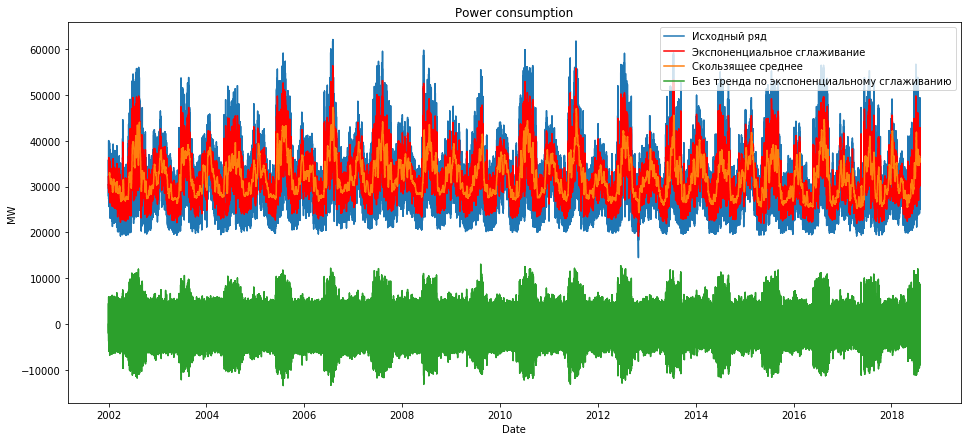

In [10]:
# show variances
plt.figure(figsize=(16,7))

plt.plot(df_MW.index, df_MW['PJME_MW'], label='Исходный ряд')
plt.plot(df_MW.index, b_ar_exp_1, color = 'red', label='Экспоненциальное сглаживание')
plt.plot(df_MW.index, df_rolling_mean, label='Скользящее среднее')
plt.plot(df_MW.index, df_no_trend, label='Без тренда по экспоненциальному сглаживанию')

plt.title('Power consumption')
plt.ylabel('MW')
plt.xlabel('Date')
plt.legend()
plt.show()

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    result = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return result

In [12]:
def train_test_split(X, y, date, h):
    """function for spliting data"""
    
    X_train = X[X.index < date]
    X_test = X[X.index >= date]
    
    y_train = y[y.index < date]
    y_test = y[y.index >= date]
    
    X_train = X_train.iloc[:-h,:]
    X_test = X_test.iloc[:-h,:]
    y_train = y_train[h:]
    y_test = y_test[h:]
    
    return X_train, X_test, y_train, y_test

In [13]:
# retyping Time
time = sorted(df_MW['Time'].unique())
index = range(len(time))

dict_time = {time[i]: i for i in index}

df_MW['Time'] = df_MW['Time'].map(dict_time).astype('int8')

In [14]:
# feature selection
columns = ['Time', 'year', 'month', 'dayofmonth', 'quarter', 'dayofyear', 'weekofyear', 
           'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday', 'is_next_holiday', 
           'PJME_MW', 'b_ar_exp_1']
Xy = df_MW[columns]

# spliting on X and y
X = Xy.drop(['PJME_MW', 'b_ar_exp_1'], axis=1)
y = Xy['b_ar_exp_1']

# date for pred
date = '01-01-2018'

In [15]:
# sploitiong on train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, date=date, h=1)

# fiting model
model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)

# predicting
y_train_pred = model_gb.predict(X_train)
y_test_pred = model_gb.predict(X_test)

y_train_pred = pd.Series(y_train_pred, index=y_train.index)
y_test_pred = pd.Series(y_test_pred, index=y_test.index) 

# viewing errors
err_train = mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred)
err_test = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
err_diff = ((err_train - err_test)**2)**(1/2)

print(f'Ошибка на train = {round(err_train, 2)}\n', 
      f'Ошибка на test = {round(err_test, 2)}\n', 
      f'Разница в ошибках = {round(err_diff, 2)}',
      sep='')

Ошибка на train = 6.19
Ошибка на test = 7.78
Разница в ошибках = 1.59


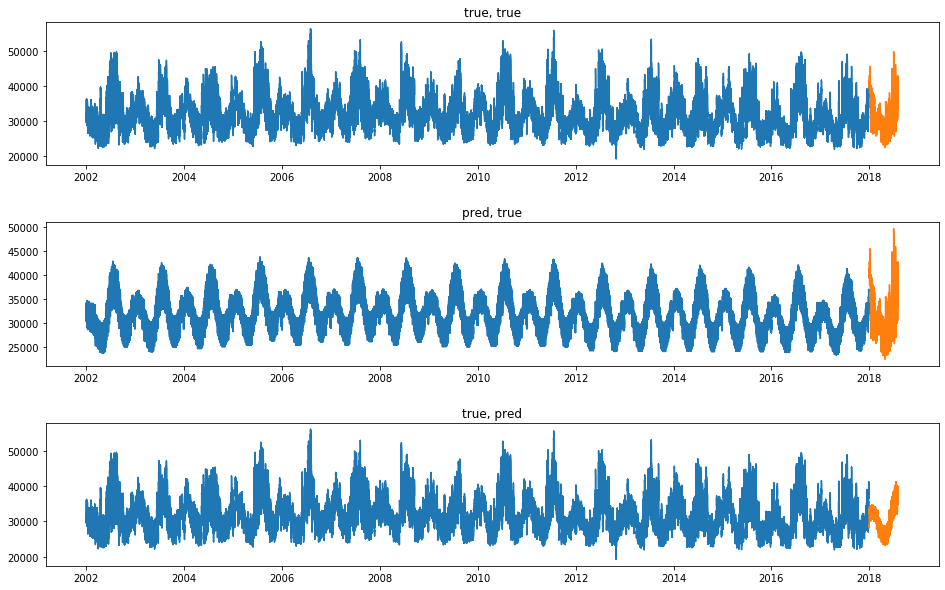

In [16]:
y_train_2017 = y_train[y_train.index < date]
y_train_pred_2017 = y_train_pred[y_train_pred.index < date]

fig, ax = plt.subplots(nrows=3, ncols=1)

ax1, ax2, ax3 = ax

ax1.plot(y_train_2017.index, y_train_2017)
ax1.plot(y_test.index, y_test)
ax1.set_title('true, true')

ax2.plot(y_train_pred_2017.index, y_train_pred_2017)
ax2.plot(y_test.index, y_test)
ax2.set_title('pred, true')

ax3.plot(y_train_2017.index, y_train_2017)
ax3.plot(y_test_pred.index, y_test_pred)
ax3.set_title('true, pred')

fig.set_size_inches(16, 10)
plt.subplots_adjust(wspace=0.1, hspace=0.4)

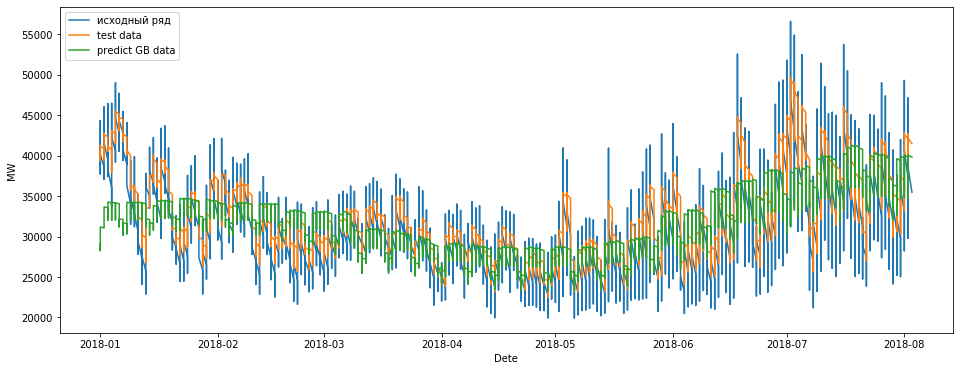

In [17]:
plt.figure(figsize=(16, 6))

plt.plot(df_MW.loc[date:].index, df_MW.loc[date:]['PJME_MW'], label='исходный ряд')
plt.plot(y_test.index, y_test, label='test data')
plt.plot(y_test_pred.index, y_test_pred, label='predict GB data')

plt.xlabel('Dete')
plt.ylabel('MW')

plt.legend()
plt.show()

In [18]:
# sploitiong on train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, date=date, h=10)

# fiting model
model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)

# predicting
y_train_pred = model_gb.predict(X_train)
y_test_pred = model_gb.predict(X_test)

y_train_pred = pd.Series(y_train_pred, index=y_train.index)
y_test_pred = pd.Series(y_test_pred, index=y_test.index) 

# viewing errors
err_train = mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred)
err_test = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
err_diff = ((err_train - err_test)**2)**(1/2)

print(f'Ошибка на train = {round(err_train, 2)}\n', 
      f'Ошибка на test = {round(err_test, 2)}\n', 
      f'Разница в ошибках = {round(err_diff, 2)}',
      sep='')

Ошибка на train = 6.18
Ошибка на test = 7.75
Разница в ошибках = 1.57


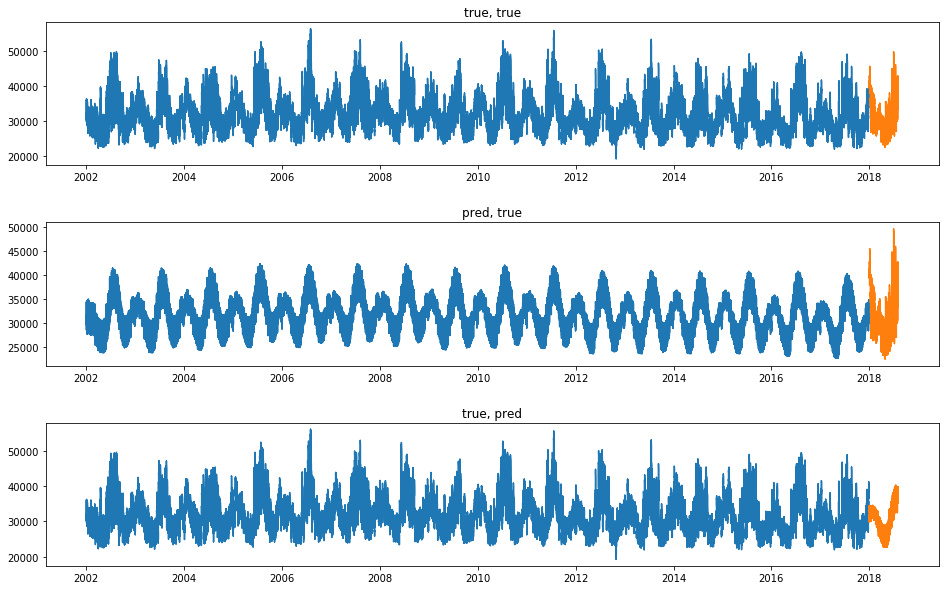

In [19]:
y_train_2017 = y_train[y_train.index < date]
y_train_pred_2017 = y_train_pred[y_train_pred.index < date]

fig, ax = plt.subplots(nrows=3, ncols=1)

ax1, ax2, ax3 = ax

ax1.plot(y_train_2017.index, y_train_2017)
ax1.plot(y_test.index, y_test)
ax1.set_title('true, true')

ax2.plot(y_train_pred_2017.index, y_train_pred_2017)
ax2.plot(y_test.index, y_test)
ax2.set_title('pred, true')

ax3.plot(y_train_2017.index, y_train_2017)
ax3.plot(y_test_pred.index, y_test_pred)
ax3.set_title('true, pred')

fig.set_size_inches(16, 10)
plt.subplots_adjust(wspace=0.1, hspace=0.4)

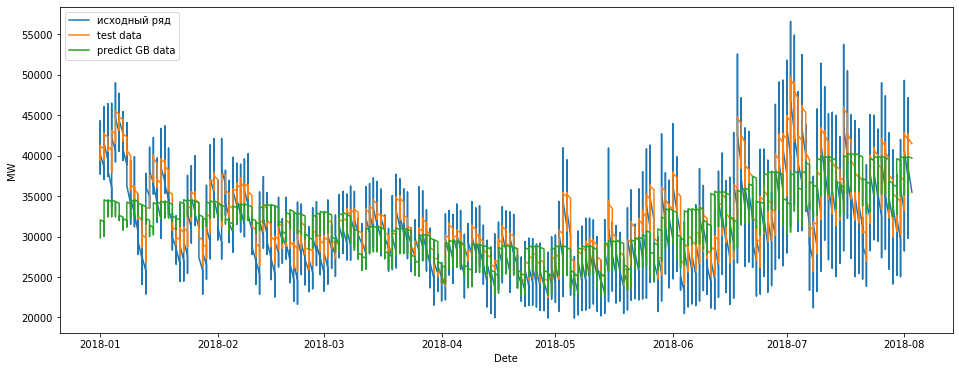

In [20]:
plt.figure(figsize=(16, 6))

plt.plot(df_MW.loc[date:].index, df_MW.loc[date:]['PJME_MW'], label='исходный ряд')
plt.plot(y_test.index, y_test, label='test data')
plt.plot(y_test_pred.index, y_test_pred, label='predict GB data')

plt.xlabel('Dete')
plt.ylabel('MW')

plt.legend()
plt.show()

2. Оцените ошибки моделей из п.1 .

- Ошибки на тесте составляют примерно

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) 
	для рядов из списка и аргументируйте свой ответ (одна строка):

	а) Изменение температуры за окном :).

	б) Количество денег, которые тратят покупатели в интернет магазине.

	в) Вес растущего котенка.

    г) Прирост объема деревьев в лесу от времени